In [428]:
try:
    import numpy as np
except ImportError:
    !python -m pip install numpy
try:
    import tensorflow
except ImportError:
    !python -m pip install tensorflow
    #python -m pip install --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.12.0-py3-none-any.whl
try:
    import sklearn
except ImportError:
    !python -m pip install scikit-learn
try:
    import pandas as pd
except ImportError:
    !python -m pip install pandas



In [429]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import pandas as pd

# Importing and Pre-processing Data

In [430]:
file_path = '..\\Data\\df.csv'
df = pd.read_csv(file_path)
df = df.drop(df.columns[0], axis=1)
print(df.head(5))

       open_time  open_price  high_price  low_price  close_price   volume  \
0  1710318900000     73504.6     73547.7    73361.0      73377.6  633.206   
1  1710319200000     73377.6     73678.0    73360.3      73670.9  624.816   
2  1710319500000     73670.9     73728.2    73463.8      73497.8  790.387   
3  1710319800000     73497.8     73568.0    73420.3      73550.2  238.801   
4  1710320100000     73550.2     73649.9    73414.4      73508.5  451.986   

       turnover  
0  4.650294e+07  
1  4.595201e+07  
2  5.816289e+07  
3  1.755326e+07  
4  3.321986e+07  


In [431]:
scaler = MinMaxScaler()

df_test = df.copy()
df_test[['open_price', 'high_price', 'low_price', 'close_price', 'volume']] = scaler.fit_transform(df_test[['open_price', 'high_price', 'low_price', 'close_price', 'volume']])

df_test = df_test.dropna()

In [432]:
# Assuming you've decided on the split percentage
split = int(0.8 * len(df))

# Training data
train_df_test = df_test[:split]

# Testing data
test_df_test = df_test[split:]

print(train_df_test)

          open_time  open_price  high_price  low_price  close_price    volume  \
0     1710318900000    0.983213    0.968891   0.977335     0.973260  0.067412   
1     1710319200000    0.973260    0.978992   0.977280     0.996246  0.066496   
2     1710319500000    0.996246    0.982884   0.985309     0.982680  0.084591   
3     1710319800000    0.982680    0.970465   0.981935     0.986787  0.024308   
4     1710320100000    0.986787    0.976814   0.981477     0.983519  0.047607   
...             ...         ...         ...        ...          ...       ...   
3995  1711517400000    0.740645    0.732455   0.747401     0.746726  0.008126   
3996  1711517700000    0.746726    0.736510   0.754398     0.749046  0.027073   
3997  1711518000000    0.749046    0.740122   0.754964     0.748521  0.013269   
3998  1711518300000    0.748521    0.733409   0.751210     0.747745  0.008130   
3999  1711518600000    0.747745    0.732634   0.750054     0.744069  0.002932   

          turnover  
0     

In [433]:
# Assuming you've decided on the split percentage
split = int(0.8 * len(df))

# Training data
train_df = df[:split]

# Testing data
test_df = df[split:]

print(train_df)


          open_time  open_price  high_price  low_price  close_price   volume  \
0     1710318900000     73504.6     73547.7    73361.0      73377.6  633.206   
1     1710319200000     73377.6     73678.0    73360.3      73670.9  624.816   
2     1710319500000     73670.9     73728.2    73463.8      73497.8  790.387   
3     1710319800000     73497.8     73568.0    73420.3      73550.2  238.801   
4     1710320100000     73550.2     73649.9    73414.4      73508.5  451.986   
...             ...         ...         ...        ...          ...      ...   
3995  1711517400000     70409.4     70497.7    70396.7      70487.0   90.737   
3996  1711517700000     70487.0     70550.0    70486.9      70516.6  264.100   
3997  1711518000000     70516.6     70596.6    70494.2      70509.9  137.794   
3998  1711518300000     70509.9     70510.0    70445.8      70500.0   90.772   
3999  1711518600000     70500.0     70500.0    70430.9      70453.1   43.211   

          turnover  
0     4.650294e+07

# Preparing the Model

## Trading Environment

In [434]:
def add_new_gaps(current_step,df,long_gaps,short_gaps,long_Gaps_Checked_Until,short_Gaps_Checked_Until,):
    
    if current_step > long_Gaps_Checked_Until:
        new_long_gaps = calculate_long_gaps(df,long_Gaps_Checked_Until,current_step)
        long_Gaps_Checked_Until = current_step - 2
        for gap in new_long_gaps:
            long_gaps.append(gap)

    if current_step > short_Gaps_Checked_Until:
        new_short_gaps = calculate_short_gaps(df,short_Gaps_Checked_Until,current_step)
        short_Gaps_Checked_Until = current_step - 2

        for gap in new_short_gaps:
            short_gaps.append(gap)
    return long_gaps, short_gaps, long_Gaps_Checked_Until, short_Gaps_Checked_Until

def check_if_gaps_are_filled(long_gaps,short_gaps,long_Gaps_Checked_Until,short_Gaps_Checked_Until,current_step,df):
    for gap in long_gaps:
        for i in range(long_Gaps_Checked_Until,current_step):
            current_candle = df.at[i, 'low_price']
            if current_candle <= gap['high_price'] and i != gap['end'] and i != gap['start'] and i != gap['end'] - 1:
                long_gaps.remove(gap)
                break
    for gap in short_gaps:
        for i in range(short_Gaps_Checked_Until,current_step):
            current_candle = df.at[i, 'high_price']
            if  current_candle >= gap['low_price'] and i != gap['end'] and i != gap['start'] and i != gap['end'] - 1:
                short_gaps.remove(gap)
                break
    
    return long_gaps, short_gaps

def calculate_long_gaps(df, current_Index, current_step):
    gaps = []
    gap_id = 1  # Start IDs from 1
    for i in range(current_Index , current_step - 1):
        first_candle = df.iloc[i]
        last_candle = df.iloc[i + 2]
        if df.at[i, 'high_price'] <= df.at[i + 2, 'low_price']:
            gap_info = {
                'id': gap_id,
                'start': i,
                'end': i + 2,
                'time': df['open_time'][i],
                'high_price': df.at[i + 2, 'low_price'],
                'low_price': df.at[i, 'high_price'],
                'stop_loss': df.at[i, 'low_price'],
                'filled': False
                }
            gaps.append(gap_info)
            gap_id += 1
        else:
            check_if_long_gaps_still_valid(df, gaps, i)

    return gaps  # Return the list of gaps for further use or analysis

def calculate_short_gaps(df, current_Index, current_step):
    gaps = []
    gap_id = 1  # Start IDs from 1
    for i in range(current_Index, current_step - 1):
        if df.at[i, 'low_price'] > df.at[i + 2, 'high_price']:
            gap_info = {
                'id': gap_id,
                'start': i,
                'end': i + 2,
                'time_high': df['open_time'][i],
                'high_price': df.at[i, 'low_price'],
                'low_price': df.at[i + 2, 'high_price'],
                'stop_loss': df.at[i, 'high_price'],
                'filled': False
                }
            gaps.append(gap_info)
            gap_id += 1
        else:
            check_if_short_gaps_still_valid(df, gaps, i)

    return gaps  # Return the list of gaps for further use or analysis

def check_if_short_gaps_still_valid(df, gaps, i):
    # Iterate backward over a copy of the gaps list to safely remove items
    for gap in gaps[::-1]:
        if df.at[i, 'high_price'] > gap['low_price']:
            # Remove the gap from the list as it's no longer needed
            gaps.remove(gap)

def check_if_long_gaps_still_valid(df, gaps, i):
    # Iterate backward over a copy of the gaps list to safely remove items
    for gap in gaps[::-1]:
        if df.at[i, 'low_price'] < gap['high_price']:
            # Remove the gap from the list as it's no longer needed
            gaps.remove(gap)


def if_current_candle_in_gap(current_step,df,long_gaps,short_gaps):
    current_candle = df.iloc[current_step]

    for gap in long_gaps[::-1]:
        if current_candle['low_price'] <= gap['high_price']:
            # long_gaps.remove(gap)
            return 1
        
    for gap in short_gaps[::-1]:
        if current_candle['high_price'] >= gap['low_price']:
            # short_gaps.remove(gap)
            return 2

    return 0

### RL Env

In [435]:
class TestEnv:
    def __init__(self, initial_balance, price_data):
        self.initial_balance = initial_balance
        self.price_data = price_data
        self.balance = initial_balance
        self.possible_action = ['Out','In']
        self.position = 0  # 0 for no position, 1 for long position, -1 for short position
        self.total_trades = 0
        self.current_step = 100
        self.long_gaps = []
        self.short_gaps = []
        self.fee_rate = 0.000055
        self.allow_trade = 0 
        self.episode_wins = 0
        self.episode_losses = 0
        self.episode_losses_To_Wins = 0 

    def reset(self):
        self.balance = self.initial_balance
        self.position = 0
        self.total_trades = 0 
        self.allow_trade = 0 
        self.current_step = 100
        self.long_gaps = []
        self.short_gaps = []
        self.episode_wins = 0
        self.episode_losses = 0
        self.episode_losses_To_Wins = 0 

    def calculate_reward(self, entry_price, current_price, position,candle_open_time):
        if position == 1:
            tradeResult = (current_price - entry_price)*self.trade_Quantity - self.trade_fee
            print('Trade Type: ', position, ' resulted in: ', tradeResult, 'at: ', candle_open_time, ' Making the account balance: ', self.balance + tradeResult)
            return tradeResult  # Profit or loss for long position
        elif position == -1:
            tradeResult = (entry_price - current_price)*self.trade_Quantity - self.trade_fee
            print('Trade Type: ', position, ' resulted in: ', tradeResult, 'at: ', candle_open_time, ' Making the account balance: ', self.balance + tradeResult)
            return tradeResult  # Profit or loss for short position


    def step(self, action):
        # Simulate the effect of taking the action (entering a trade)
        # For simplicity, let's assume we're either entering a long position (1) or not (0)
        reward = 0
        current_price_low = self.price_data.at[self.current_step, 'low_price']
        current_price_high = self.price_data.at[self.current_step, 'high_price']
        open_time = self.price_data.at[self.current_step,'open_time']
        if action == 'In' and self.position == 0:  # Enter long position
            
            if self.allow_trade == 1:
                self.attempt_to_enter_long_trade(current_price_low,open_time)
            elif self.allow_trade == 2:
                self.attempt_to_enter_short_trade(current_price_high,open_time)


        if self.position == 1:
            if current_price_high >= self.tp or current_price_low <= self.sl:
                random_number = random.random()
                close_price = 0

                if random_number >= 0.5:
                    if current_price_high >= self.tp:
                        close_price = self.tp
                    else:
                        close_price = self.sl
                else:
                    if current_price_low <= self.sl:
                        close_price = self.sl
                    else:
                        close_price = self.tp

                reward = self.calculate_reward(self.entry_price, close_price , self.position,open_time)
                self.balance += reward

                if reward < 0:
                    self.episode_losses += 1
                    self.episode_losses_To_Wins -=1
                else:
                    self.episode_wins +=1
                    self.episode_losses_To_Wins +=1

                print('Long Trade Closed')
                self.position = 0  # Reset position

        elif self.position == -1:
            #If Trade should be closed
            if current_price_low <= self.tp or current_price_high >= self.sl:
                random_number = random.random()
                close_price = 0

                #Since the candle low/high might hit both the TP and SP we simply make it 50/50 which one is checked first
                if random_number >= 0.5:
                    if current_price_high >= self.sl:
                        close_price = self.sl
                    else:
                        close_price = self.tp
                else:
                    if current_price_low <= self.tp:
                        close_price = self.tp
                    else:
                        close_price = self.sl

                reward = self.calculate_reward(self.entry_price, close_price , self.position,open_time)
                self.balance += reward
                if reward < 0:
                    self.episode_losses += 1
                    self.episode_losses_To_Wins -=1
                else:
                    self.episode_wins +=1
                    self.episode_losses_To_Wins +=1

                
                print('Short Trade Closed')
                self.position = 0  # Reset position   
        
        self.current_step += 1
        
        # Get the next state (observation)
        next_state = self.price_data.iloc[self.current_step]
        if(self.current_step == len(self.price_data) - 2):
            return next_state, reward, True

        return next_state, reward, False
    
    def attempt_to_enter_long_trade(self,current_price_low,candle_open_time):
        for gap in self.long_gaps:
            if current_price_low <= gap['high_price']:

                self.total_trades +=1
                self.position = 1
                        
                self.entry_price = gap['high_price']
                self.sl = gap['stop_loss']
                stop_loss_in_perc = 1 - self.sl / self.entry_price
                money_risk = self.balance * 0.02
                self.trade_Value = money_risk / stop_loss_in_perc
                tp_in_perc = stop_loss_in_perc * 2
                self.tp = self.entry_price * (1 + tp_in_perc)


                self.trade_Quantity = self.trade_Value / self.entry_price
                self.trade_fee = self.trade_Value * self.fee_rate

                self.current_Trade = { "Position Type" : 'Long',
                                            "Entry Price" : self.entry_price,
                                            "Trade total Value" : self.trade_Value,
                                            "Quantity" : self.trade_Quantity,
                                            "Take Profit " : self.tp,
                                            "Stop Loss " : self.sl,
                                            "Entry Time" : candle_open_time
                                            }
                        
                print("Entering a Long Trade at - ", self.entry_price, ' at: ', candle_open_time)

                
                self.long_gaps.remove(gap)
                return True

    def attempt_to_enter_short_trade(self,current_price_high,candle_open_time):
            for gap in self.short_gaps:
                if current_price_high >= gap['low_price']:
                    self.total_trades +=1
                    self.position = -1


                    self.entry_price =  gap['low_price']
                    self.sl = gap['stop_loss']
                    stop_loss_in_perc = 1 - self.entry_price/ self.sl
                    money_risk = self.balance * 0.03
                    self.trade_Value = money_risk / stop_loss_in_perc
                    tp_in_perc = stop_loss_in_perc * 2
                    self.tp = self.entry_price * (1 - tp_in_perc)

                    self.trade_Quantity = self.trade_Value / self.entry_price
                    self.trade_fee = self.trade_Value * self.fee_rate

                    self.current_Trade = { "Position Type" : 'Short',
                                                "Entry Price" : self.entry_price,
                                                "Trade total Value" : self.trade_Value,
                                                "Quantity" : self.trade_Quantity,
                                                "Take Profit " : self.tp,
                                                "Stop Loss " : self.sl,
                                                "Entry Time" : candle_open_time
                                                }
                            
                    print("Entering a Short Trade Trade at - ", self.entry_price, ' at: ', candle_open_time)

                    self.short_gaps.remove(gap)
                    break
    
    def set_gaps(self,long_gaps,short_gaps):
        self.long_gaps = long_gaps
        self.short_gaps = short_gaps

    def set_trade_type(self,allow_trade):
        self.allow_trade = allow_trade

In [4]:


closest_num = closest_power_of_2(80000)
print(closest_num)

65536


### RL Agent

In [436]:
import pickle

# Load the saved model from the file
with open('kmeans_model.pkl', 'rb') as f:
    kmeans_model = pickle.load(f)

In [437]:
print(train_df.iloc[0])
print(type(train_df.iloc[0]))

open_time      1.710319e+12
open_price     7.350460e+04
high_price     7.354770e+04
low_price      7.336100e+04
close_price    7.337760e+04
volume         6.332060e+02
turnover       4.650294e+07
Name: 0, dtype: float64
<class 'pandas.core.series.Series'>


In [438]:
# Convert the Series to DataFrame and transpose it
new_df = train_df.iloc[0].to_frame().T

# Drop the index
new_df.reset_index(drop=True, inplace=True)
new_df.drop('open_time', axis=1, inplace=True)
state_cluster = kmeans_model.predict(new_df)
print(state_cluster)


[31]


In [439]:
# Define parameters
initial_balance = 100
price_data = train_df
print(len(price_data))
num_episodes = 10 
totalRewards = np.zeros(num_episodes)
totalWins = np.zeros(num_episodes)
totalLoses = np.zeros(num_episodes)
totalWinsToLoses = np.zeros(num_episodes)
epsilon = 1
alpha = 0.1
gamma = 1
num_features = len(price_data)
states = [row.to_list() for _, row in price_data.iterrows()]

4000


In [440]:
# Define your RL agent
class RLAgent:
    def __init__(self, states, actions):
        self.Q = {}
        self.possible_actions = actions
        for i in range (200):
            for action in actions:
                self.Q[(i, action)] = 0

    def actionSpaceSample(self):
        return np.random.choice(self.possible_actions)

    def maxAction(self,Q, state_cluster, actions):
        # print(state)
        # state_cluster = self.convert_state_to_cluster(state)
        values = np.array([Q[state_cluster,a] for a in actions])
        action = np.argmax(values)
        return actions[action]
    
    def choose_action(self, state, epsilon, allow_trade):
        
        state_cluster = self.convert_state_to_cluster(state)
        rand = np.random.rand()
        action = self.maxAction(self.Q,state_cluster[0], self.possible_actions) if rand < (1-epsilon) \
                                                    else self.actionSpaceSample()
        return action
        
    def learn(self, state, action, reward, next_state, alpha, gamma):
        # Convert next_state to a tuple
        next_state_cluter = self.convert_state_to_cluster(next_state)
        state_cluster = self.convert_state_to_cluster(state)

        action_ = self.maxAction(self.Q, next_state_cluter[0], self.possible_actions)
        self.Q[next_state_cluter[0],action] = self.Q[state_cluster[0],action] + alpha*(reward + \
                        gamma*self.Q[next_state_cluter[0],action_] - self.Q[state_cluster[0],action])
        
    def convert_state_to_cluster(self,state):
        converted_state = state.to_frame().T
        converted_state.drop('open_time', axis=1, inplace=True)
        converted_state.reset_index(drop=True, inplace=True)
        
        return kmeans_model.predict(converted_state)
        



Starting New Episode
Starting Episode № 1
Entering a Long Trade at -  72759.5  at:  1710350100000
Trade Type:  1  resulted in:  3.9409332472324725 at:  1710351300000  Making the account balance:  103.94093324723248
Long Trade Closed
Entering a Long Trade at -  72904.4  at:  1710352200000
Trade Type:  1  resulted in:  4.103650759220822 at:  1710354600000  Making the account balance:  108.0445840064533
Long Trade Closed
Entering a Long Trade at -  73157.2  at:  1710355500000
Trade Type:  1  resulted in:  -2.193963810844851 at:  1710357900000  Making the account balance:  105.85062019560846
Long Trade Closed
Entering a Long Trade at -  73020.1  at:  1710358200000
Trade Type:  1  resulted in:  4.195396251900065 at:  1710360600000  Making the account balance:  110.04601644750852
Long Trade Closed
Entering a Short Trade Trade at -  73043.7  at:  1710361200000
Trade Type:  -1  resulted in:  -3.3751760396187733 at:  1710361200000  Making the account balance:  106.67084040788974
Short Trade Clo

Entering a Long Trade at -  73025.8  at:  1710378300000
Trade Type:  1  resulted in:  -2.1501002501103335 at:  1710378300000  Making the account balance:  102.34839546694543
Long Trade Closed
Entering a Long Trade at -  73025.8  at:  1710378600000
Trade Type:  1  resulted in:  -2.105861038303479 at:  1710378600000  Making the account balance:  100.24253442864196
Long Trade Closed
Entering a Long Trade at -  73101.9  at:  1710378900000
Trade Type:  1  resulted in:  -2.03619093624119 at:  1710378900000  Making the account balance:  98.20634349240078
Long Trade Closed
Entering a Long Trade at -  73110.5  at:  1710379200000
Trade Type:  1  resulted in:  -2.0587125748000035 at:  1710379200000  Making the account balance:  96.14763091760078
Long Trade Closed
Entering a Long Trade at -  73094.3  at:  1710379800000
Trade Type:  1  resulted in:  -1.9835374785121955 at:  1710379800000  Making the account balance:  94.16409343908859
Long Trade Closed
Entering a Long Trade at -  72986.1  at:  1710

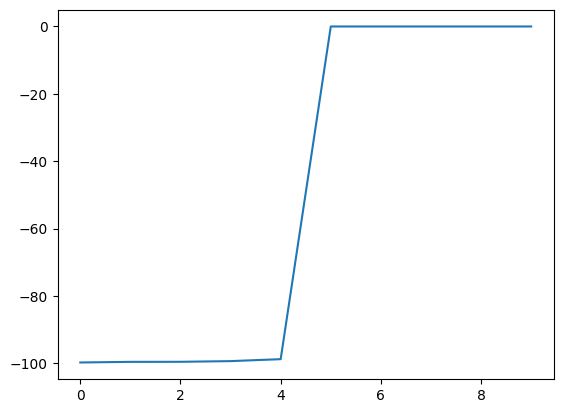

In [441]:
# Create trading environment and RL agent
env = TestEnv(initial_balance, price_data)
agent = RLAgent(states=states, actions=env.possible_action)  # 2 actions: enter trade or not
num = 0
# Train RL agent
for episode in range(num_episodes):
    print('Starting New Episode')
    long_gaps = []
    short_gaps = []
    long_Gaps_Checked_Until = 0
    short_Gaps_Checked_Until = 0
    ep_rewards = 0
    env.reset()
    state, done = env.price_data.iloc[env.current_step], False
    long_gaps, short_gaps, long_Gaps_Checked_Until, short_Gaps_Checked_Until = add_new_gaps(env.current_step,price_data,long_gaps,short_gaps,long_Gaps_Checked_Until,short_Gaps_Checked_Until)
    allow_trade = 0  # Flag to indicate whether to allow trades
    num = num + 1
    print("Starting Episode №",num)
    while not done:
        # long_gaps, short_gaps = check_if_gaps_are_filled(long_gaps,short_gaps,long_Gaps_Checked_Until,short_Gaps_Checked_Until,env.current_step,df)
        allow_trade = if_current_candle_in_gap(env.current_step,price_data,long_gaps,short_gaps)
        env.set_trade_type(allow_trade)
        env.set_gaps(long_gaps,short_gaps)
        
        action = agent.choose_action(state, epsilon, allow_trade)
        next_state, reward, done = env.step(action)
        ep_rewards += reward
        agent.learn(state, action, reward, next_state, alpha, gamma)

        state = next_state
        long_gaps, short_gaps, long_Gaps_Checked_Until, short_Gaps_Checked_Until = add_new_gaps(env.current_step,price_data,long_gaps,short_gaps,long_Gaps_Checked_Until,short_Gaps_Checked_Until)
        # print(ep_rewards) 
    
    if epsilon - 2 / num_episodes > 0:
        epsilon -= 2 / num_episodes
    else:
        epsilon = 0
    
    totalRewards[episode] = ep_rewards
    totalWins[episode] = env.episode_wins
    totalLoses[episode] = env.episode_losses
    totalWinsToLoses[episode] = env.episode_losses_To_Wins


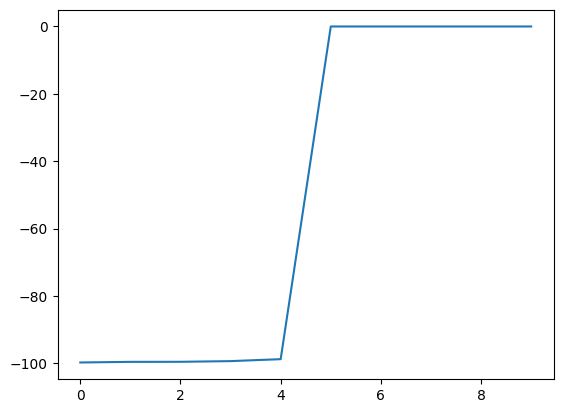

In [446]:
plt.plot(totalRewards)
plt.show()

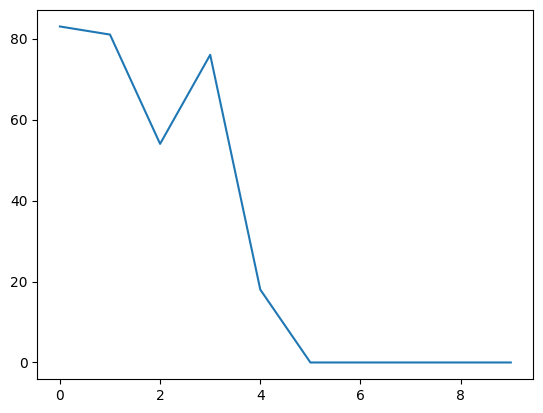

In [442]:
plt.plot(totalWins)
plt.show()

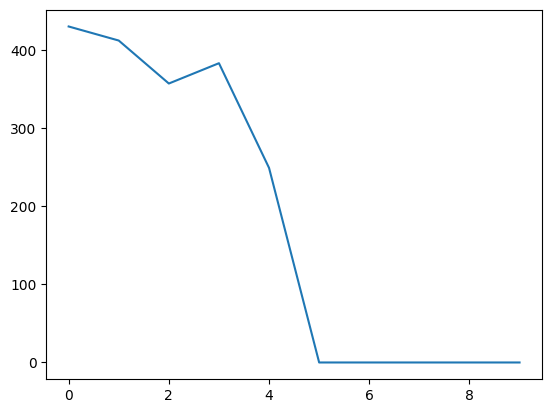

In [443]:
plt.plot(totalLoses)
plt.show()

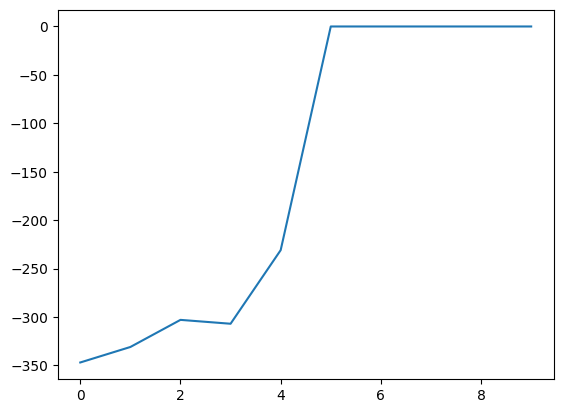

In [444]:
plt.plot(totalWinsToLoses)
plt.show()

In [445]:
print(agent.Q)

{(0, 'Out'): 1.8978939678711324, (0, 'In'): 1.866457582150489, (1, 'Out'): 1.8978939674021331, (1, 'In'): 1.4978574213457911, (2, 'Out'): 1.8978939680215967, (2, 'In'): 1.8136767183905633, (3, 'Out'): 0, (3, 'In'): 0, (4, 'Out'): 1.8978939678710733, (4, 'In'): 1.8499243480544765, (5, 'Out'): 1.8978939678725657, (5, 'In'): 1.7804742642394242, (6, 'Out'): 1.8978939371420998, (6, 'In'): 1.404918907469721, (7, 'Out'): 1.8978961086554391, (7, 'In'): 0.9870989342202647, (8, 'Out'): 1.8978939679269162, (8, 'In'): 1.6554535391816116, (9, 'Out'): 1.8978939678740447, (9, 'In'): 1.8242360258707926, (10, 'Out'): 1.8978939681964504, (10, 'In'): 1.535117586064725, (11, 'Out'): 1.8978939679755837, (11, 'In'): 1.5724097880911987, (12, 'Out'): 1.897893967870444, (12, 'In'): 1.8569723914162166, (13, 'Out'): 1.8978944636432615, (13, 'In'): 1.7589821723675105, (14, 'Out'): 1.8978939679322704, (14, 'In'): 1.7713281730494714, (15, 'Out'): 1.8978939678797113, (15, 'In'): 1.8026255450605921, (16, 'Out'): 0, (